## PINN framework for laminated plates
This framework predicts the bending behavior of laminated plates based on Classical Laminate Plate Theory (CLPT). Taking a simply supported (0/90) plate under uniform distributed load (UDL) as an example, other cases can be predicted by modifying the parameters in the code.

## Import libraries

In [806]:
# Essential libraries
import numpy as np
import pandas as pd
import math
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from tqdm import trange

In [807]:
import os, random

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


In [808]:
# Clear CUDA cache and check for available device (GPU or CPU)
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device} (CUDA available: {torch.cuda.is_available()})")

Using device: cuda (CUDA available: True)


## Define neural network

In [809]:
# Define FNN
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=[20, 20, 5], activation='tanh'):

        super(NeuralNetwork, self).__init__()
        layers = []
        layers.append(nn.Linear(input_size, hidden_size[0]))
        if activation == 'relu':
            layers.append(nn.ReLU())
        elif activation == 'sigmoid':
            layers.append(nn.Sigmoid())
        elif activation == 'tanh':
            layers.append(nn.Tanh())
        else:
            layers.append(nn.Softplus())

        for i in range(len(hidden_size) - 1):
            layers.append(nn.Linear(hidden_size[i], hidden_size[i+1]))
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'sigmoid':
                layers.append(nn.Sigmoid())
            elif activation == 'tanh':
                layers.append(nn.Tanh())
            else:
                layers.append(nn.Softplus())

        layers.append(nn.Linear(hidden_size[-1], output_size))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [810]:
# Auto differential
def auto_grad(u, x, order=1):
    if order == 1:
        return torch.autograd.grad(u, x, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    return auto_grad(auto_grad(u, x), x, order - 1)

# Xavier initialization
def xavier_init(layer):
    if isinstance(layer, nn.Linear):
        nn.init.xavier_uniform_(layer.weight)  # Xavier initialization for weights
        nn.init.zeros_(layer.bias)  # Initialize biases to zero

## CLPT stiffness matrix

In [811]:
# Calculate the transformed matrix
def transformed_matrix(phi,opt):

    anpha=np.deg2rad(phi)
    m=math.cos(anpha)
    n=math.sin(anpha)
    if abs(m) < 2.2204e-10:
        m=0
    if abs(n) < 2.2204e-10:
        n=0

    if opt==1:
        T = np.array([[m**2, n**2, 2*m*n ],
                   [n**2, m**2, -2*m*n ],
                   [-m*n, m*n, m**2-n**2]])
    else:
        T = np.array([[m**2, n**2, m*n ],
                   [n**2, m**2, -m*n ],
                   [-2*m*n, 2*m*n, m**2-n**2]])
    return T

In [812]:
# Define geometric parameters
a = 5
b = 5
h = 1 # Total thickness of the laminate
n_layer = 2 # Number of layers
t = h/n_layer # Thickness of each layer
phi = [0,90] # lay-ups
q0 = 1e-3
# SDL: q0 * torch.sin(3.1415/2*(x[:,0]+1)).view(-1,1)* torch.sin(3.1415/2*(x[:,1]+1)).view(-1,1)

# Define material parameters
E1 = 25
E2 = E1/25
G12 = 0.5*E2
mu12 = 0.25
mu21 = mu12*E2/E1

# Stiffness matrix for an orthotropic material
Q11 = E1/(1 - mu12*mu21)
Q12 = mu12*E2/(1 - mu12*mu21)
Q22 = E2/(1 - mu12*mu21)
Q66 = G12
Q = np.array([[Q11, Q12 , 0],[Q12 , Q22, 0],[0, 0, Q66]])

# Transform stiffness matrix for each layer
Q_bar =[]
for i in range(n_layer):
        T2=transformed_matrix(phi[i],2)
        Q2=T2.T@Q@T2
        Q_bar.append(Q2)

# Calculate z-coordinates for each layer
z1 = []
for i in range(n_layer):
    zi=((i)-n_layer/2)*t
    z1.append(zi)
z1 = np.array(z1)

z2 = []
for i in range(n_layer):
    zi=((i+1)-n_layer/2)*t
    z2.append(zi)
z2 = np.array(z2)

# Compute A, B, D matrices
A = np.zeros(shape=(3,3))
B = np.zeros(shape=(3,3))
D = np.zeros(shape=(3,3))
for i in range(n_layer):
    A = A + Q_bar[i] * (z2[i] - z1[i])
    B = B + Q_bar[i] * (z2[i]**2 - z1[i]**2)/2
    D = D + Q_bar[i] * (z2[i]**3 - z1[i]**3)/3
print("A matrix:\n", A)
print("B matrix:\n", B)
print("D matrix:\n", D)

A matrix:
 [[13.03258145  0.25062657  0.        ]
 [ 0.25062657 13.03258145  0.        ]
 [ 0.          0.          0.5       ]]
B matrix:
 [[-3.0075188  0.         0.       ]
 [ 0.         3.0075188  0.       ]
 [ 0.         0.         0.       ]]
D matrix:
 [[1.08604845 0.02088555 0.        ]
 [0.02088555 1.08604845 0.        ]
 [0.         0.         0.04166667]]


## Training data

In [813]:
# Define sampling point
def train_data(Nx, Ny, Nf):

    xu = np.linspace(-1, 1, Nx).reshape([Nx, 1])
    yu = np.linspace(-1, 1, Ny).reshape([Ny, 1])
    X, Y = np.meshgrid(xu, yu)
    Xf1 = np.vstack([X.ravel(), Y.ravel()]).T
    Xf1 = torch.tensor(Xf1, dtype=torch.float32, requires_grad=True)

    Xf2 = np.random.rand(Nf,2)*2-1
    Xf2 = torch.tensor(Xf2, dtype=torch.float32, requires_grad=True)

    return Xf1, Xf2

In [814]:
# Prepare training data
Nxb= 100
Nyb = 100
Nf1 = 10000

Xf1, Xf2 = train_data(Nxb, Nyb, Nf1)

## Loss function

In [815]:
def Energy_loss(x, Net_w, func_w, Net_u, func_u, Net_v, func_v):

    q = q0
    # SDL: q = q0 * torch.sin(3.1415/2*(x[:,0]+1)).view(-1,1)* torch.sin(3.1415/2*(x[:,1]+1)).view(-1,1)
    u = Net_u(x)*(func_u(x).view(-1,1))
    du_x = auto_grad(u, x, 1)[:,0].view(-1,1)
    du_y = auto_grad(u, x, 1)[:,1].view(-1,1)
    v = Net_v(x)*(func_v(x).view(-1,1))
    dv_x = auto_grad(v, x, 1)[:,0].view(-1,1)
    dv_y = auto_grad(v, x, 1)[:,1].view(-1,1)
    w = Net_w(x)*(func_w(x).view(-1,1))
    dw_x = auto_grad(w, x, 1)[:,0].view(-1,1)
    dw_y = auto_grad(w, x, 1)[:,1].view(-1,1)
    dw_xx = auto_grad(dw_x, x, 1)[:,0].view(-1,1)
    dw_yy = auto_grad(dw_y, x, 1)[:,1].view(-1,1)
    dw_xy = auto_grad(dw_x, x, 1)[:,1].view(-1,1)

    w = w*h
    dw_x, dw_y, du_y, dv_x = dw_x*h/a, dw_y*h/b, du_y*a/b, dv_x*b/a
    dw_xx, dw_yy, dw_xy = dw_xx*h/a**2, dw_yy*h/b**2, dw_xy*h/a/b

    eps_xx = du_x + 0.5*dw_x**2
    eps_yy = dv_y + 0.5*dw_y**2
    eps_xy = 0.5*(du_y + dv_x) + 0.5*dw_y*dw_x

    k_xx = -dw_xx
    k_yy = -dw_yy
    k_xy = -dw_xy

    N_xx = A[0,0]*eps_xx + A[0,1]*eps_yy + A[0,2]*2*eps_xy  + B[0,0]*k_xx + B[0,1]*k_yy + B[0,2]*2*k_xy
    N_yy = A[1,0]*eps_xx + A[1,1]*eps_yy + A[1,2]*2*eps_xy  + B[1,0]*k_xx + B[1,1]*k_yy + B[1,2]*2*k_xy
    N_xy = A[2,0]*eps_xx + A[2,1]*eps_yy + A[2,2]*2*eps_xy  + B[2,0]*k_xx + B[2,1]*k_yy + B[2,2]*2*k_xy

    M_xx = B[0,0]*eps_xx + B[0,1]*eps_yy + B[0,2]*2*eps_xy  + D[0,0]*k_xx + D[0,1]*k_yy + D[0,2]*2*k_xy
    M_yy = B[1,0]*eps_xx + B[1,1]*eps_yy + B[1,2]*2*eps_xy  + D[1,0]*k_xx + D[1,1]*k_yy + D[1,2]*2*k_xy
    M_xy = B[2,0]*eps_xx + B[2,1]*eps_yy + B[2,2]*2*eps_xy  + D[2,0]*k_xx + D[2,1]*k_yy + D[2,2]*2*k_xy

    U_m = 0.5*(eps_xx*N_xx + eps_yy*N_yy + 2*eps_xy*N_xy)
    U_b = 0.5*(k_xx*M_xx + k_yy*M_yy + 2*k_xy*M_xy)
    U_e = q*w

    return torch.mean(U_m), torch.mean(U_b), torch.mean(U_e)

## Training Model

In [816]:
# Independent nn for three directions
Net_w = NeuralNetwork(input_size=2, output_size=1, hidden_size=[40, 40, 40, 40, 40], activation='tanh').to(device)
Net_u = NeuralNetwork(input_size=2, output_size=1, hidden_size=[40, 40, 40, 40, 40], activation='tanh').to(device)
Net_v = NeuralNetwork(input_size=2, output_size=1, hidden_size=[40, 40, 40, 40, 40], activation='tanh').to(device)
Net_w.apply(xavier_init)
Net_u.apply(xavier_init)
Net_v.apply(xavier_init)


NeuralNetwork(
  (network): Sequential(
    (0): Linear(in_features=2, out_features=40, bias=True)
    (1): Tanh()
    (2): Linear(in_features=40, out_features=40, bias=True)
    (3): Tanh()
    (4): Linear(in_features=40, out_features=40, bias=True)
    (5): Tanh()
    (6): Linear(in_features=40, out_features=40, bias=True)
    (7): Tanh()
    (8): Linear(in_features=40, out_features=40, bias=True)
    (9): Tanh()
    (10): Linear(in_features=40, out_features=1, bias=True)
  )
)

In [817]:
# ===== constants =====
BC_MODE = 'hard'      # 'hard' or 'soft'
DATA_ASSIST = True     # enable data-assisted loss

# FEM csv and splits
FEM_CSV_PATH   = 'FEM.csv'
FEM_TRAIN_FRAC = 0.02
FEM_VAL_FRAC   = 0.00
FEM_TEST_FRAC  = 0.00
FEM_RANDOM_SEED = 42

# stress scaling: set True if FEM.csv stores nondimensional overbar stresses
STRESS_IS_NONDIM = True
STRESS_SCALE = (h**2) / (q0 * (2*a)**2)

# location
PLY_INDEX_FOR_SIGMA = 1     # 0-based layer index
PLY_Z = 0.5           # z in [-0.5,0.5]; 0 mid-surface, +0.5 top, -0.5 bottom

# weights inside data-assisted term
L_DATA_WEIGHTS = {"sigma": 1.0}

# BC mode switch
def get_bc_funcs(mode: str):
    if mode.lower() == 'hard':
        f_w = lambda x: (x[:,0]+1)*(x[:,0]-1)*(x[:,1]+1)*(x[:,1]-1)
        f_u = lambda x: (x[:,1]+1)*(x[:,1]-1)
        f_v = lambda x: (x[:,0]+1)*(x[:,0]-1)
    else:  # 'soft'
        f_w = lambda x: torch.ones(x.shape[0], device=x.device, dtype=torch.float32)
        f_u = lambda x: torch.ones(x.shape[0], device=x.device, dtype=torch.float32)
        f_v = lambda x: torch.ones(x.shape[0], device=x.device, dtype=torch.float32)
    return f_w, f_u, f_v

func_w, func_u, func_v = get_bc_funcs(BC_MODE)


In [818]:
# ===== for soft BCs =====
def make_boundary_points(Nb=400, device=device, requires_grad=True):
    s = torch.linspace(-1.0, 1.0, Nb, device=device)
    Xtop   = torch.stack([s,  torch.ones_like(s)], dim=1).requires_grad_(requires_grad)
    Xbot   = torch.stack([s, -torch.ones_like(s)], dim=1).requires_grad_(requires_grad)
    Xleft  = torch.stack([-torch.ones_like(s), s], dim=1).requires_grad_(requires_grad)
    Xright = torch.stack([ torch.ones_like(s), s], dim=1).requires_grad_(requires_grad)
    return Xtop, Xbot, Xleft, Xright

def soft_bc_loss(Net_w, Net_u, Net_v, Xtop, Xbot, Xleft, Xright,
                 w_w=1.0, w_slope=2.0, w_u=0.1, w_v=0.1):
    # w=0
    w_t = Net_w(Xtop);  w_b = Net_w(Xbot);  w_l = Net_w(Xleft);  w_r = Net_w(Xright)
    Lw = (w_t**2).mean() + (w_b**2).mean() + (w_l**2).mean() + (w_r**2).mean()

    # ∂w/∂n = 0
    dw_top   = auto_grad(Net_w(Xtop),   Xtop,   1)[:, 1:2] * (h / b)
    dw_bot   = auto_grad(Net_w(Xbot),   Xbot,   1)[:, 1:2] * (h / b)
    dw_left  = auto_grad(Net_w(Xleft),  Xleft,  1)[:, 0:1] * (h / a)
    dw_right = auto_grad(Net_w(Xright), Xright, 1)[:, 0:1] * (h / a)
    Lslope = (dw_top**2).mean() + (dw_bot**2).mean() + (dw_left**2).mean() + (dw_right**2).mean()

    # u=0，v=0
    u_t = Net_u(Xtop);  u_b = Net_u(Xbot)
    v_l = Net_v(Xleft); v_r = Net_v(Xright)
    Lu = (u_t**2).mean() + (u_b**2).mean()
    Lv = (v_l**2).mean() + (v_r**2).mean()

    return w_w*Lw + w_slope*Lslope + w_u*Lu + w_v*Lv

# boundary points
if BC_MODE.lower() == 'soft':
    Xtop, Xbot, Xleft, Xright = make_boundary_points(Nb=400, device=device, requires_grad=True)


In [819]:
# ===== data-assist =====
def _to_ref_square(coords_np: np.ndarray) -> np.ndarray:
    mins = coords_np.min(axis=0); maxs = coords_np.max(axis=0)
    spans = np.maximum(maxs - mins, 1e-12)
    return 2.0 * (coords_np - mins) / spans - 1.0

def load_fem_splits3_random(csv_path: str, frac_train: float, frac_val: float, frac_test: float,
                            seed: int, device, dtype=torch.float32):
    df = pd.read_csv(csv_path)

    coords = df.iloc[:, [0, 1]].to_numpy(dtype=np.float32)   # X,Y
    coords_ref = _to_ref_square(coords)             # [-1,1]^2
    N = coords_ref.shape[0]

    rng = np.random.default_rng(seed)
    k_tr = max(1, int(round(frac_train * N)))
    k_va = max(0, int(round(frac_val   * N)))
    k_te = max(0, int(round(frac_test  * N)))

    all_idx = np.arange(N)
    idx_tr = rng.choice(N, size=k_tr, replace=False)

    remain = np.setdiff1d(all_idx, idx_tr, assume_unique=True)
    if (k_va == 0) and (k_te == 0):
        idx_va = np.empty((0,), dtype=int)
        idx_te = remain
    else:
        idx_va = rng.choice(remain, size=min(k_va, remain.size), replace=False)
        remain2 = np.setdiff1d(remain, idx_va, assume_unique=True)
        idx_te = rng.choice(remain2, size=min(k_te, remain2.size), replace=False)

    def _mk(Xidx):
        if Xidx.size == 0:
            return None, None, None, Xidx
        Xd = torch.tensor(coords_ref[Xidx, :], dtype=dtype, device=device, requires_grad=True)
        sigma_t = torch.tensor(df.iloc[Xidx, 3:6].to_numpy(dtype=np.float32),
                               dtype=dtype, device=device)
        return Xd, None, sigma_t, Xidx

    tr = _mk(idx_tr)
    va = _mk(idx_va)
    te = _mk(idx_te)
    return tr, va, te


In [820]:
# ===== predict ω and σ =====
def predict_w_sigma(X_inp):
    u = Net_u(X_inp) * func_u(X_inp).view(-1,1)
    v = Net_v(X_inp) * func_v(X_inp).view(-1,1)
    w = Net_w(X_inp) * func_w(X_inp).view(-1,1)

    du = auto_grad(u, X_inp, 1); dv = auto_grad(v, X_inp, 1); dw = auto_grad(w, X_inp, 1)
    du_x, du_y = du[:,0:1], du[:,1:2]
    dv_x, dv_y = dv[:,0:1], dv[:,1:2]
    dw_x, dw_y = dw[:,0:1], dw[:,1:2]
    dw_xx = auto_grad(dw_x, X_inp, 1)[:,0:1]
    dw_yy = auto_grad(dw_y, X_inp, 1)[:,1:2]
    dw_xy = auto_grad(dw_x, X_inp, 1)[:,1:2]

    w_phys = w * h
    dw_x  = dw_x * h / a;  dw_y  = dw_y * h / b
    du_y  = du_y * a / b;  dv_x  = dv_x * b / a
    dw_xx = dw_xx * h / (a**2); dw_yy = dw_yy * h / (b**2); dw_xy = dw_xy * h / (a*b)

    eps_xx = du_x + 0.5 * dw_x**2
    eps_yy = dv_y + 0.5 * dw_y**2
    eps_xy = 0.5 * (du_y + dv_x) + 0.5 * dw_x * dw_y
    k_xx, k_yy, k_xy = -dw_xx, -dw_yy, -dw_xy

    Qb = Q_bar[PLY_INDEX_FOR_SIGMA]
    s_xx = Qb[0,0]*eps_xx + Qb[0,1]*eps_yy + Qb[0,2]*2*eps_xy + PLY_Z*(Qb[0,0]*k_xx + Qb[0,1]*k_yy + Qb[0,2]*2*k_xy)
    s_yy = Qb[1,0]*eps_xx + Qb[1,1]*eps_yy + Qb[1,2]*2*eps_xy + PLY_Z*(Qb[1,0]*k_xx + Qb[1,1]*k_yy + Qb[1,2]*2*k_xy)
    s_xy = Qb[2,0]*eps_xx + Qb[2,1]*eps_yy + Qb[2,2]*2*eps_xy + PLY_Z*(Qb[2,0]*k_xx + Qb[2,1]*k_yy + Qb[2,2]*2*k_xy)

    sigma_pred = torch.cat([s_xx, s_yy, s_xy], dim=1)
    return w_phys, sigma_pred


In [821]:
if DATA_ASSIST:
    (Xd_train, w_train, sigma_train, idx_train), \
    (Xd_val,   w_val,   sigma_val,   idx_val), \
    (Xd_test,  w_test,  sigma_test,  idx_test) = load_fem_splits3_random(
        FEM_CSV_PATH, FEM_TRAIN_FRAC, FEM_VAL_FRAC, FEM_TEST_FRAC, FEM_RANDOM_SEED, device
    )

In [822]:
# ===== Choose optimizer =====
params = list(Net_w.parameters()) + list(Net_u.parameters()) + list(Net_v.parameters())
optimizer_Adam = torch.optim.Adam(params, lr=0.001)
optimizer_LBFGS = torch.optim.LBFGS(params, lr=0.001, max_iter=50000, max_eval=50000, history_size=50,
                                   tolerance_grad=1e-5, tolerance_change=1.0 * np.finfo(float).eps,
                                   line_search_fn="strong_wolfe")

scheduler = torch.optim.lr_scheduler.StepLR(optimizer_Adam, step_size=200, gamma=0.9)

In [823]:
# ===== history containers  =====
loss_hist = {
    "epoch": [],
    "loss_total": [],
    "U_m": [],
    "U_b": [],
    "U_e": [],
    "L_BC": [],       # raw BC penalty
    "lambda_BC": [],     # adaptive lambda_BC
    "L_data": [],      # raw data penalty
    "lambda_data": []    # adaptive lambda_data
}

In [824]:
# ================= Train the model =====================
epochs = 2000
initial_epochs = 100
td = trange(epochs, dynamic_ncols=True, ncols=50)

training_loss_hist = []
W_pred_hist = []

Net_u.train().to(device)
Net_v.train().to(device)
Net_w.train().to(device)

# ----- Adaptive soft-BC weighting -----
ADAPTIVE_BC = True         # λ_BC
LBC_EMA_DECAY = 0.98        # EMA
LBC_TARGET_SCALE = 1
LBC_MIN, LBC_MAX = 1e-3, 5.0
ema_phys = None           # EMA(U_m+U_b)
ema_bc   = None          # EMA(L_BC)

# ----- Adaptive data-assist weighting -----
ADAPTIVE_DATA        = True   # λ_data
LDATA_EMA_DECAY      = 0.98
LDATA_TARGET_SCALE   = 0.5
LDATA_MIN, LDATA_MAX = 1e-3, 2.0
ema_data = None            # EMA(L_data)

for epoch in td:
    if epoch < initial_epochs:
        Xf1, _ = train_data(Nxb, Nyb, Nf1)
        Xf = Xf1.to(device)
    else:
        _, Xf2 = train_data(Nxb, Nyb, Nf1)
        Xf = Xf2.to(device)

    # physical energy
    U_m, U_b, U_e = Energy_loss(Xf, Net_w, func_w, Net_u, func_u, Net_v, func_v)
    loss = U_m + U_b - U_e

    # ------ soft-BC -------
    if BC_MODE.lower() == 'soft':
        L_BC = soft_bc_loss(Net_w, Net_u, Net_v, Xtop, Xbot, Xleft, Xright)

        if ADAPTIVE_BC:
            with torch.no_grad():
                phys_scale = (U_m + U_b).detach()
                bc_scale   = L_BC.detach()

                if ema_phys is None:
                    ema_phys = phys_scale
                    ema_bc   = bc_scale
                else:
                    ema_phys = LBC_EMA_DECAY * ema_phys + (1.0 - LBC_EMA_DECAY) * phys_scale
                    ema_bc   = LBC_EMA_DECAY * ema_bc   + (1.0 - LBC_EMA_DECAY) * bc_scale

                ratio = (ema_phys / (ema_bc + 1e-12)).clamp(min=LBC_MIN, max=LBC_MAX)
                lambda_BC = (LBC_TARGET_SCALE * ratio).item()
        else:
            lambda_BC = min(1.0, 1e-3 * (epoch + 1))  # linear λ

        loss = loss + lambda_BC * L_BC

    # ------- data-assist --------
    if DATA_ASSIST:
        _, sigma_pred = predict_w_sigma(Xd_train)
        sigma_pred_for_loss = sigma_pred * STRESS_SCALE if STRESS_IS_NONDIM else sigma_pred
        L_data = torch.mean((sigma_pred_for_loss - sigma_train) ** 2)

        if ADAPTIVE_DATA:
            with torch.no_grad():
                phys_scale = (U_m + U_b).detach()
                data_scale = L_data.detach()

                if ema_data is None:
                    ema_data = data_scale
                    if ema_phys is None:
                        ema_phys = phys_scale
                else:
                    ema_data = LDATA_EMA_DECAY * ema_data + (1.0 - LDATA_EMA_DECAY) * data_scale
                    ema_phys = LDATA_EMA_DECAY * ema_phys + (1.0 - LDATA_EMA_DECAY) * phys_scale

                ratio = (ema_phys / (ema_data + 1e-12)).clamp(min=LDATA_MIN, max=LDATA_MAX)
                lambda_data = (LDATA_TARGET_SCALE * ratio).item()
        else:
            lambda_data = min(1.0, 1e-3 * (epoch + 1))  # linear λ

        loss = loss + lambda_data * L_data

    # ---- backwards and record -----
    loss.backward()
    optimizer_Adam.step()
    optimizer_Adam.zero_grad()
    training_loss_hist.append(loss.item())
    scheduler.step()

    if (epoch + 1) % 1 == 0:
        with torch.no_grad():
            W_pred = (
                Net_w(Xf1.to(device)) * func_w(Xf1.to(device)).view(-1, 1)
                * 100 * (h)**3 * E2 / q0 / (2*a)**4
            )
            W_pred = W_pred.cpu()
            W_pred_hist.append(max(W_pred))

    # ---- record losses for this epoch ----
    L_BC_val        = float(L_BC.item()) if ('L_BC' in locals() or 'L_BC' in globals()) else float('nan')
    lambda_BC_val   = float(lambda_BC)   if ('lambda_BC' in locals() or 'lambda_BC' in globals()) else float('nan')
    L_data_val      = float(L_data.item()) if ('L_data' in locals() or 'L_data' in globals()) else float('nan')
    lambda_data_val = float(lambda_data) if ('lambda_data' in locals() or 'lambda_data' in globals()) else float('nan')

    loss_hist["epoch"].append(epoch + 1)
    loss_hist["loss_total"].append(float(loss.item()))
    loss_hist["U_m"].append(float(U_m.item()))
    loss_hist["U_b"].append(float(U_b.item()))
    loss_hist["U_e"].append(float(U_e.item()))
    loss_hist["L_BC"].append(L_BC_val)
    loss_hist["lambda_BC"].append(lambda_BC_val)
    loss_hist["L_data"].append(L_data_val)
    loss_hist["lambda_data"].append(lambda_data_val)

    td.set_description(
        f" Total:{loss:.2e}, Um:{U_m:.2e}, Ub:{U_b:.2e}, Ue:{U_e:.4e}, Wmax:{max(W_pred).item():.4f}"
        + (f", lBC:{lambda_BC:.3f}"   if (BC_MODE.lower() == 'soft') else "")
        + (f", lDATA:{lambda_data:.3f}" if DATA_ASSIST else "")
    )


 Total:-3.02e-05, Um:3.53e-07, Ub:3.48e-05, Ue:6.7718e-05, Wmax:1.6333, lDATA:0.004: 100%|██████████| 2000/2000 [05:33<00:00,  6.00it/s]


,epoch,loss_total,U_m,U_b,U_e,L_BC,lambda_BC,L_data,lambda_data,U_phys,L_BC_eff,L_data_eff
1990,1991,-0.000016,-2.284381e-06,0.000038,0.000068,0.072108,0.001,0.004141,0.003924,-0.000032,0.000072,0.000016
1991,1992,-0.000029,4.314646e-06,0.000031,0.000068,0.072108,0.001,0.000858,0.003986,-0.000032,0.000072,0.000003
1992,1993,-0.000032,2.819464e-06,0.000033,0.000069,0.072108,0.001,0.000363,0.004058,-0.000033,0.000072,0.000001
1993,1994,-0.000024,-1.431613e-06,0.000037,0.000068,0.072108,0.001,0.002181,0.004098,-0.000033,0.000072,0.000009
1994,1995,-0.000010,9.372498e-06,0.000027,0.000068,0.072108,0.001,0.005008,0.004088,-0.000031,0.000072,0.000020
1995,1996,0.000002,-3.607838e-06,0.000041,0.000069,0.072108,0.001,0.008312,0.004022,-0.000032,0.000072,0.000033
1996,1997,0.000008,1.317530e-05,0.000025,0.000068,0.072108,0.001,0.009466,0.003941,-0.000030,0.000072,0.000037
1997,1998,-0.000001,-3.291871e-06,0.000040,0.000068,0.072108,0.001,0.007664,0.003891,-0.000031,0.000072,0.000030
1998,1999,-0.000019,7.682905e-06,0.000029,0.000068,0.072108,0.001,0.003288,0.003914,-0.000032,0.000072,0.000013
1999,2000,-0.000030,3.530109e-07,0.000035,0.000068,0.072108,0.001,0.000581,0.003981,-0.000033,0.000072,0.000002


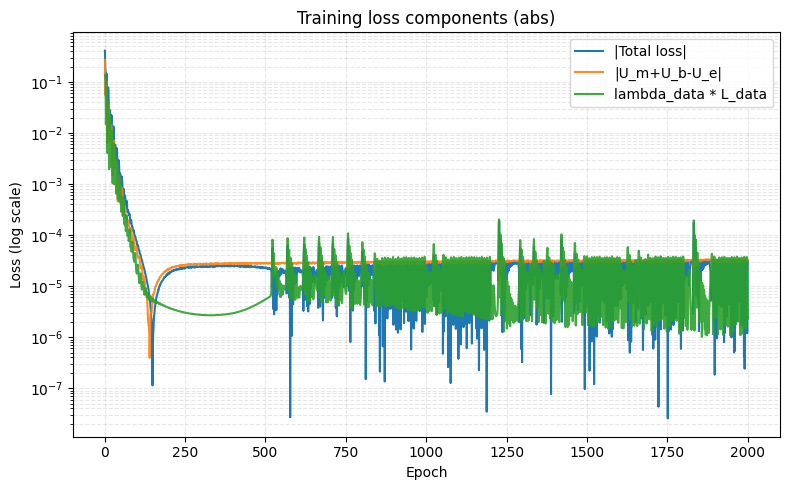

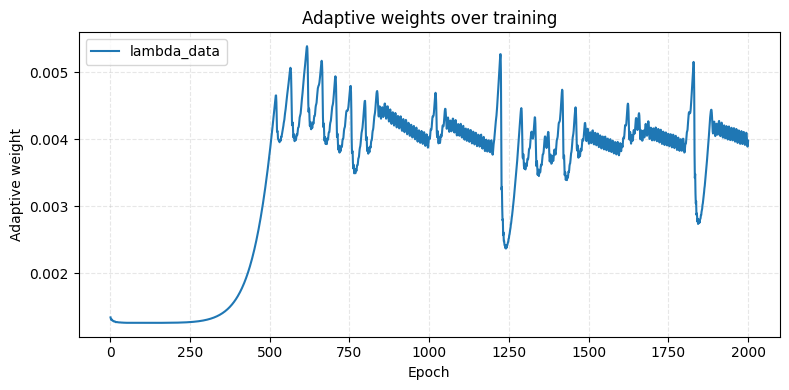

In [825]:
# ===== table and plots =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) DataFrame
df_loss = pd.DataFrame(loss_hist)

# Compatibility processing
def _get(col, default=0.0):
    return df_loss[col] if col in df_loss.columns else pd.Series(default, index=df_loss.index, dtype=float)

df_loss["U_phys"]     = _get("U_m") + _get("U_b") - _get("U_e")
df_loss["L_BC_eff"]   = _get("L_BC")   * _get("lambda_BC")
df_loss["L_data_eff"] = _get("L_data") * _get("lambda_data")

# save CSV
df_loss.to_csv("training_losses.csv", index=False)

# preview last 10 lines
try:
    from IPython.display import display
    display(df_loss.tail(10))
except Exception:
    print(df_loss.tail(10))

# 2) plot loss curve
def _semilogy_abs(ax, x, y, label, **kw):
    y = np.asarray(y, dtype=float)
    y = np.abs(y)              # abs value
    y[y == 0] = np.nan
    ax.semilogy(x, y, label=label, **kw)

epochs_arr = df_loss["epoch"].to_numpy()

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
_semilogy_abs(ax, epochs_arr, _get("loss_total"), label="|Total loss|")
_semilogy_abs(ax, epochs_arr, df_loss["U_phys"],  label="|U_m+U_b-U_e|", alpha=0.9)

# if np.nanmax(np.abs(df_loss["L_BC_eff"])) > 0:
#     _semilogy_abs(ax, epochs_arr, df_loss["L_BC_eff"], label="lambda_BC * L_BC", alpha=0.9)
if np.nanmax(np.abs(df_loss["L_data_eff"])) > 0:
    _semilogy_abs(ax, epochs_arr, df_loss["L_data_eff"], label="lambda_data * L_data", alpha=0.9)

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss (log scale)")
ax.set_title("Training loss components (abs)")
ax.grid(True, which="both", ls="--", alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

# 3) plot λ
has_lbc   = "lambda_BC"   in df_loss.columns and not np.all(np.isnan(df_loss["lambda_BC"]))
has_ldata = "lambda_data" in df_loss.columns and not np.all(np.isnan(df_loss["lambda_data"]))

if has_lbc or has_ldata:
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    # if has_lbc:
    #     ax.plot(epochs_arr, df_loss["lambda_BC"],   label="lambda_BC")
    if has_ldata:
        ax.plot(epochs_arr, df_loss["lambda_data"], label="lambda_data")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Adaptive weight")
    ax.set_title("Adaptive weights over training")
    ax.grid(True, ls="--", alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()


## Deformation predictions

In [826]:
Net_w.eval().cpu()
Net_u.eval().cpu()
Net_v.eval().cpu()
W = Net_w(Xf1)*(func_w(Xf1).view(-1,1))
W_pred = W.detach().numpy().reshape(-1,1)*h
W_bar = W_pred*100*(h)**3*E2/q0/(2*a)**4
X = Xf1[:,0].detach().numpy().reshape(-1,1)*a
Y = Xf1[:,1].detach().numpy().reshape(-1,1)*b

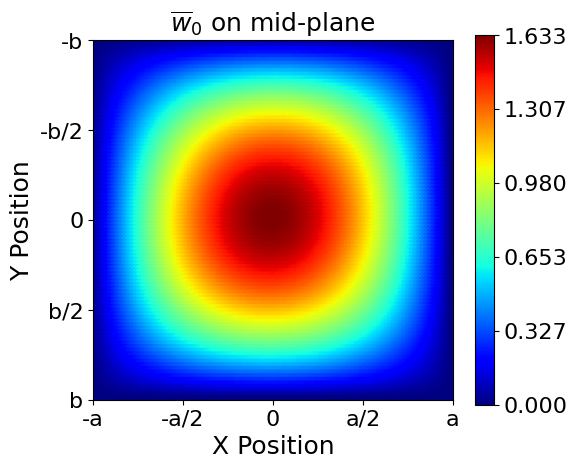

In [827]:
plt.rcParams['font.family'] = 'DejaVu Sans'
fig, ax = plt.subplots(figsize=(5.8, 4.8))
surf = ax.scatter(X, Y, c=W_bar,cmap=cm.jet)
cb = fig.colorbar(surf, ax=ax, orientation='vertical')
cb.ax.tick_params(labelsize=16)
vmin = W_bar.min().item()
vmax = W_bar.max().item()
num_ticks = 6
ticks = np.linspace(vmin, vmax, num_ticks)
cb.set_ticks(ticks)

ax.axis('equal')
ax.set_xlabel('X Position (mm)', fontsize=18)
ax.set_ylabel('Y Position (mm)', fontsize=18)

ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_title(r'$\overline{w}_{0}$ on mid-plane', fontsize=18)
ax.set_xlim([X.min(), X.max()])
ax.set_ylim([Y.max(), Y.min()])
xticks = [-5, -2.5, 0, 2.5, 5]
xlabels = ['-a', '-a/2', '0', 'a/2', 'a']
yticks = [-5, -2.5, 0, 2.5, 5]
ylabels = ['-b', '-b/2', '0', 'b/2', 'b']
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels, fontsize=16)
ax.set_yticks(yticks)
ax.set_yticklabels(ylabels, fontsize=16)
ax.set_xlabel('X Position', fontsize=18)
ax.set_ylabel('Y Position', fontsize=18)
ax.set_aspect('equal', adjustable='box')

plt.show()

## Results from FEM

In [828]:
FEM_data = pd.read_csv('FEM.csv')

In [829]:
coord = FEM_data.iloc[:, 0:2].to_numpy(dtype=np.float32)
mins  = coord.min(axis=0)
maxs  = coord.max(axis=0)
spans = np.maximum(maxs - mins, 1e-12)
coord_nor = 2.0 * (coord - mins) / spans - 1.0   # 与训练里的 _to_ref_square 完全一致
X = coord_nor[:, 0];  Y = coord_nor[:, 1]

sigma = FEM_data.iloc[:,3:6].to_numpy()
sigmaxx = sigma[:, 0].reshape(-1, 1)
sigmayy = sigma[:, 1].reshape(-1, 1)
sigmaxy = sigma[:, 2].reshape(-1, 1)

In [830]:
# color bar range
vmin_xx, vmax_xx = float(sigmaxx.min()), float(sigmaxx.max())
vmin_yy, vmax_yy = float(sigmayy.min()), float(sigmayy.max())
vxy = float(max(abs(sigmaxy.min()), abs(sigmaxy.max())))
vmin_xy, vmax_xy = -vxy, vxy


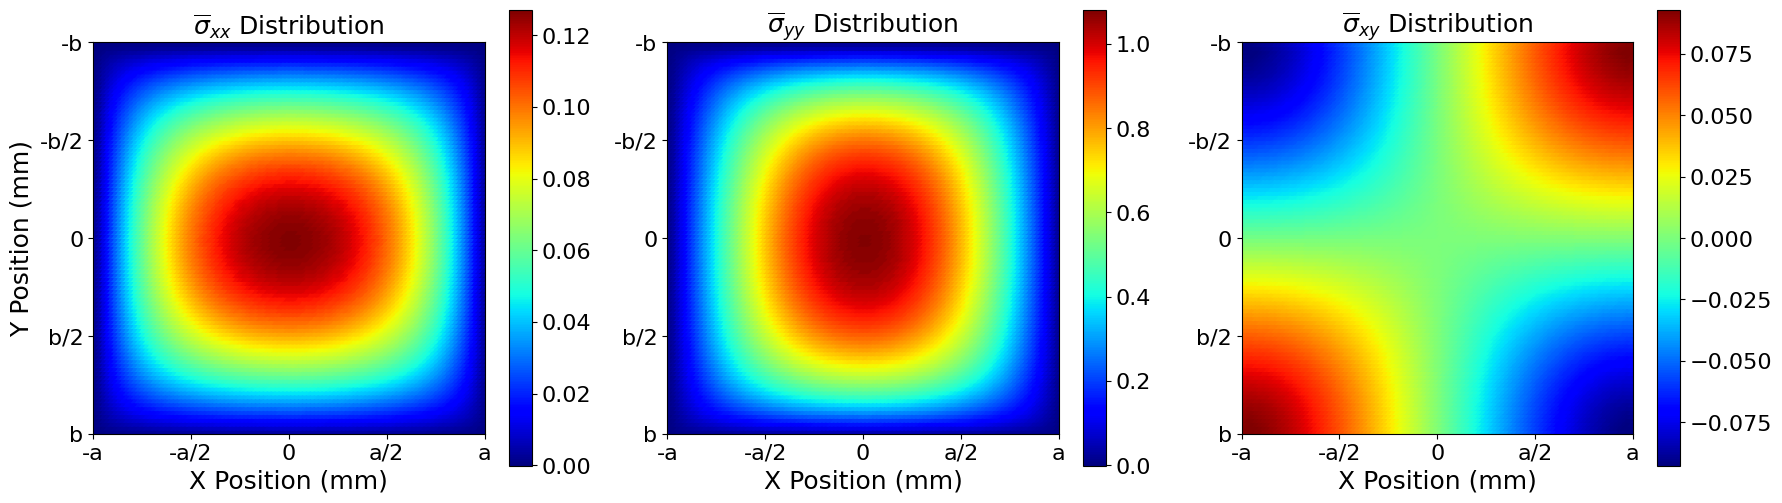

In [831]:
plt.rcParams['font.family'] = 'DejaVu Sans'

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
xticks = [-1, -0.5, 0, 0.5, 1]
xlabels = ['-a', '-a/2', '0', 'a/2', 'a']
yticks = [-1, -0.5, 0, 0.5, 1]
ylabels = ['-b', '-b/2', '0', 'b/2', 'b']

# σ_xx
sc1 = axes[0].scatter(X, Y, c=sigmaxx, vmin=vmin_xx, vmax=vmax_xx, cmap=cm.jet)
cb1 = fig.colorbar(sc1, ax=axes[0], orientation='vertical', shrink=0.8)
cb1.ax.tick_params(labelsize=16)
axes[0].set_xlabel('X Position (mm)', fontsize=18)
axes[0].set_ylabel('Y Position (mm)', fontsize=18)
axes[0].set_title(r'$\overline{\sigma}_{xx}$ Distribution', fontsize=18)
axes[0].tick_params(axis='both', which='major', labelsize=16)
axes[0].set_xlim([X.min(), X.max()]); axes[0].set_ylim([Y.max(), Y.min()])
axes[0].set_xticks(xticks); axes[0].set_xticklabels(xlabels, fontsize=16)
axes[0].set_yticks(yticks); axes[0].set_yticklabels(ylabels, fontsize=16)
axes[0].set_aspect('equal', adjustable='box')

# σ_yy
sc2 = axes[1].scatter(X, Y, c=sigmayy, vmin=vmin_yy, vmax=vmax_yy, cmap=cm.jet)
cb2 = fig.colorbar(sc2, ax=axes[1], orientation='vertical', shrink=0.8)
cb2.ax.tick_params(labelsize=16)
axes[1].set_xlabel('X Position (mm)', fontsize=18)
axes[1].set_title(r'$\overline{\sigma}_{yy}$ Distribution', fontsize=18)
axes[1].tick_params(axis='both', which='major', labelsize=16)
axes[1].set_xlim([X.min(), X.max()]); axes[1].set_ylim([Y.max(), Y.min()])
axes[1].set_xticks(xticks); axes[1].set_xticklabels(xlabels, fontsize=16)
axes[1].set_yticks(yticks); axes[1].set_yticklabels(ylabels, fontsize=16)
axes[1].set_aspect('equal', adjustable='box')

# σ_xy
sc3 = axes[2].scatter(X, Y, c=sigmaxy, vmin=vmin_xy, vmax=vmax_xy, cmap=cm.jet)
cb3 = fig.colorbar(sc3, ax=axes[2], orientation='vertical', shrink=0.8)
cb3.ax.tick_params(labelsize=16)
axes[2].set_xlabel('X Position (mm)', fontsize=18)
axes[2].set_title(r'$\overline{\sigma}_{xy}$ Distribution', fontsize=18)
axes[2].tick_params(axis='both', which='major', labelsize=16)
axes[2].set_xlim([X.min(), X.max()]); axes[2].set_ylim([Y.max(), Y.min()])
axes[2].set_xticks(xticks); axes[2].set_xticklabels(xlabels, fontsize=16)
axes[2].set_yticks(yticks); axes[2].set_yticklabels(ylabels, fontsize=16)
axes[2].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

## Results from the Model

In [832]:
X_inp = torch.tensor(coord_nor, dtype=torch.float32, requires_grad=True)
u = Net_u(X_inp)*(func_u(X_inp).view(-1,1))
du_x = auto_grad(u, X_inp, 1)[:,0].view(-1,1)
du_y = auto_grad(u, X_inp, 1)[:,1].view(-1,1)
v = Net_v(X_inp)*(func_v(X_inp).view(-1,1))
dv_x = auto_grad(v, X_inp, 1)[:,0].view(-1,1)
dv_y = auto_grad(v, X_inp, 1)[:,1].view(-1,1)
w = Net_w(X_inp)*(func_w(X_inp).view(-1,1))
dw_x = auto_grad(w, X_inp, 1)[:,0].view(-1,1)
dw_y = auto_grad(w, X_inp, 1)[:,1].view(-1,1)
dw_xx = auto_grad(dw_x, X_inp, 1)[:,0].view(-1,1)
dw_yy = auto_grad(dw_y, X_inp, 1)[:,1].view(-1,1)
dw_xy = auto_grad(dw_x, X_inp, 1)[:,1].view(-1,1)

w = w*h
dw_x, dw_y, du_y, dv_x = dw_x*h/a, dw_y*h/b, du_y*a/b, dv_x*b/a
dw_xx, dw_yy, dw_xy = dw_xx*h/a**2, dw_yy*h/b**2, dw_xy*h/a/b

eps_xx = du_x + 0.5*dw_x**2
eps_yy = dv_y + 0.5*dw_y**2
eps_xy = 0.5*(du_y + dv_x) + 0.5*dw_y*dw_x

k_xx = -dw_xx
k_yy = -dw_yy
k_xy = -dw_xy

N_xx = A[0,0]*eps_xx + A[0,1]*eps_yy + A[0,2]*2*eps_xy  + B[0,0]*k_xx + B[0,1]*k_yy + B[0,2]*2*k_xy
N_yy = A[1,0]*eps_xx + A[1,1]*eps_yy + A[1,2]*2*eps_xy  + B[1,0]*k_xx + B[1,1]*k_yy + B[1,2]*2*k_xy
N_xy = A[2,0]*eps_xx + A[2,1]*eps_yy + A[2,2]*2*eps_xy  + B[2,0]*k_xx + B[2,1]*k_yy + B[2,2]*2*k_xy

M_xx = B[0,0]*eps_xx + B[0,1]*eps_yy + B[0,2]*2*eps_xy  + D[0,0]*k_xx + D[0,1]*k_yy + D[0,2]*2*k_xy
M_yy = B[1,0]*eps_xx + B[1,1]*eps_yy + B[1,2]*2*eps_xy  + D[1,0]*k_xx + D[1,1]*k_yy + D[1,2]*2*k_xy
M_xy = B[2,0]*eps_xx + B[2,1]*eps_yy + B[2,2]*2*eps_xy  + D[2,0]*k_xx + D[2,1]*k_yy + D[2,2]*2*k_xy

In [833]:
PINN_sigmaxx = Q_bar[1][0,0]*eps_xx + Q_bar[1][0,1]*eps_yy + Q_bar[1][0,2]*2*eps_xy + 0.5* ( Q_bar[1][0,0]*k_xx +  Q_bar[1][0,1]*k_yy +  Q_bar[1][0,2]*2*k_xy )
PINN_sigmayy = Q_bar[1][1,0]*eps_xx + Q_bar[1][1,1]*eps_yy + Q_bar[1][1,2]*2*eps_xy + 0.5* ( Q_bar[1][1,0]*k_xx +  Q_bar[1][1,1]*k_yy +  Q_bar[1][1,2]*2*k_xy )
PINN_sigmaxy = Q_bar[1][2,0]*eps_xx + Q_bar[1][2,1]*eps_yy + Q_bar[1][2,2]*2*eps_xy + 0.5* ( Q_bar[1][2,0]*k_xx +  Q_bar[1][2,1]*k_yy +  Q_bar[1][2,2]*2*k_xy )


In [834]:
PINN_sigmaxx = PINN_sigmaxx.detach().cpu().numpy()*(h**2)/(q0*(2*a)**2)
PINN_sigmayy = PINN_sigmayy.detach().cpu().numpy()*(h**2)/(q0*(2*a)**2)
PINN_sigmaxy = PINN_sigmaxy.detach().cpu().numpy()*(h**2)/(q0*(2*a)**2)


In [835]:
N_total = sigmaxx.shape[0]
if 'DATA_ASSIST' in globals() and DATA_ASSIST and 'idx_train' in globals():
    mask = np.ones(N_total, dtype=bool)
    mask[np.array(idx_train, dtype=int)] = False
else:
    mask = slice(None)

def _r2(yp, yt):
    yp = np.asarray(yp).reshape(-1)
    yt = np.asarray(yt).reshape(-1)
    num = np.sum((yp - yt)**2)
    den = np.sum((yt - yt.mean())**2) + 1e-12
    return float(1.0 - num/den)

sigmaxx_r2 = _r2(PINN_sigmaxx[mask], sigmaxx[mask])
sigmayy_r2 = _r2(PINN_sigmayy[mask], sigmayy[mask])
sigmaxy_r2 = _r2(PINN_sigmaxy[mask], sigmaxy[mask])

print("R-squared (sigmaxx):", sigmaxx_r2)
print("R-squared (sigmayy):", sigmayy_r2)
print("R-squared (sigmaxy):", sigmaxy_r2)

R-squared (sigmaxx): 0.9648109420614457
R-squared (sigmayy): 0.9782205034401734
R-squared (sigmaxy): 0.9820722246036082


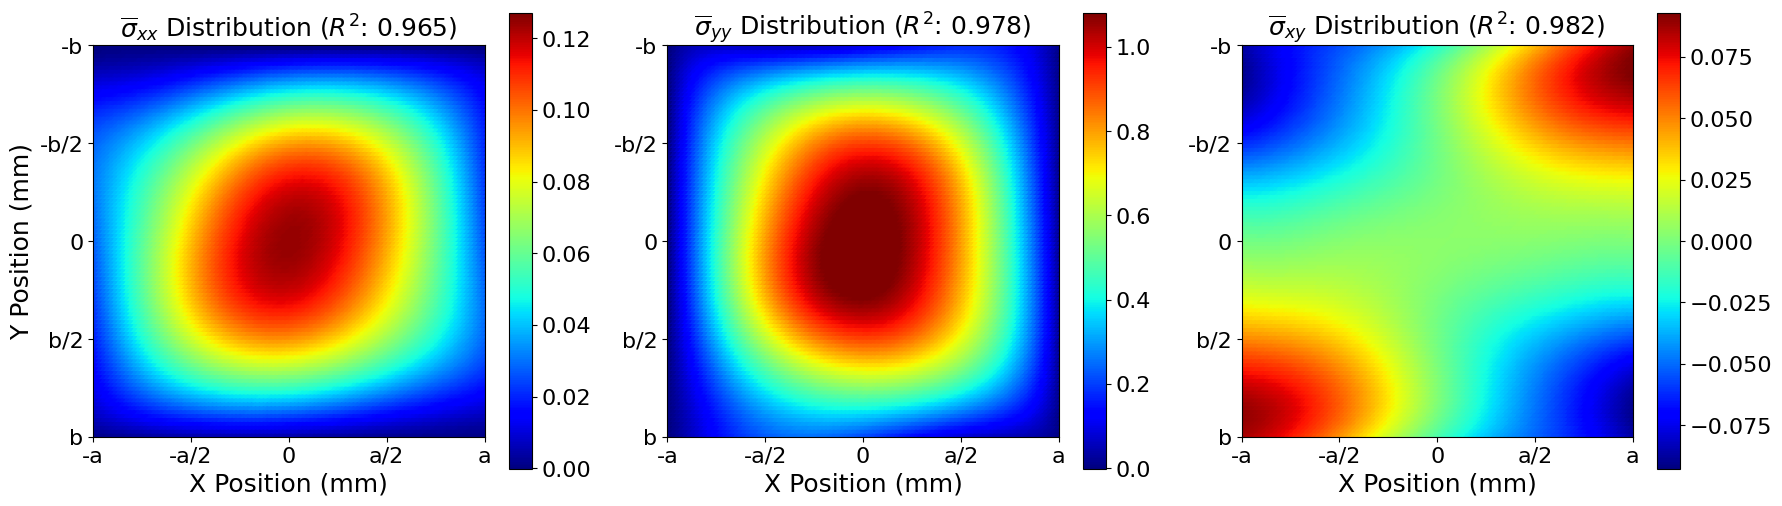

In [836]:
plt.rcParams['font.family'] = 'DejaVu Sans'

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
xticks = [-1, -0.5, 0, 0.5, 1]
xlabels = ['-a', '-a/2', '0', 'a/2', 'a']
yticks = [-1, -0.5, 0, 0.5, 1]
ylabels = ['-b', '-b/2', '0', 'b/2', 'b']

sc1 = axes[0].scatter(X, Y, c=PINN_sigmaxx, vmin=vmin_xx, vmax=vmax_xx, cmap=cm.jet)
cb1 = fig.colorbar(sc1, ax=axes[0], orientation='vertical', shrink=0.8)
cb1.ax.tick_params(labelsize=16)
axes[0].set_xlabel('X Position (mm)', fontsize=18)
axes[0].set_ylabel('Y Position (mm)', fontsize=18)
axes[0].set_title(fr'$\overline{{\sigma}}_{{xx}}$ Distribution ($R^2$: {sigmaxx_r2:.3f})', fontsize=18)
axes[0].tick_params(axis='both', which='major', labelsize=16)
axes[0].set_xlim([X.min(), X.max()]); axes[0].set_ylim([Y.max(), Y.min()])
axes[0].set_xticks(xticks); axes[0].set_xticklabels(xlabels, fontsize=16)
axes[0].set_yticks(yticks); axes[0].set_yticklabels(ylabels, fontsize=16)
axes[0].set_aspect('equal', adjustable='box')

sc2 = axes[1].scatter(X, Y, c=PINN_sigmayy, vmin=vmin_yy, vmax=vmax_yy, cmap=cm.jet)  # 注意：不再写 vmin=0
cb2 = fig.colorbar(sc2, ax=axes[1], orientation='vertical', shrink=0.8)
cb2.ax.tick_params(labelsize=16)
axes[1].set_xlabel('X Position (mm)', fontsize=18)
axes[1].set_title(fr'$\overline{{\sigma}}_{{yy}}$ Distribution ($R^2$: {sigmayy_r2:.3f})', fontsize=18)
axes[1].tick_params(axis='both', which='major', labelsize=16)
axes[1].set_xlim([X.min(), X.max()]); axes[1].set_ylim([Y.max(), Y.min()])
axes[1].set_xticks(xticks); axes[1].set_xticklabels(xlabels, fontsize=16)
axes[1].set_yticks(yticks); axes[1].set_yticklabels(ylabels, fontsize=16)
axes[1].set_aspect('equal', adjustable='box')

sc3 = axes[2].scatter(X, Y, c=PINN_sigmaxy, vmin=vmin_xy, vmax=vmax_xy, cmap=cm.jet)
cb3 = fig.colorbar(sc3, ax=axes[2], orientation='vertical', shrink=0.8)
cb3.ax.tick_params(labelsize=16)
axes[2].set_xlabel('X Position (mm)', fontsize=18)
axes[2].set_title(fr'$\overline{{\sigma}}_{{xy}}$ Distribution ($R^2$: {sigmaxy_r2:.3f})', fontsize=18)
axes[2].tick_params(axis='both', which='major', labelsize=16)
axes[2].set_xlim([X.min(), X.max()]); axes[2].set_ylim([Y.max(), Y.min()])
axes[2].set_xticks(xticks); axes[2].set_xticklabels(xlabels, fontsize=16)
axes[2].set_yticks(yticks); axes[2].set_yticklabels(ylabels, fontsize=16)
axes[2].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

### End